In [1]:
pip install wfdb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import wfdb
from scipy.signal import butter, filtfilt, find_peaks
from scipy.fftpack import dct
from scipy.stats import skew, kurtosis
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
ptb_path = "/kaggle/input/hci-projectdataset-ecg/"
patients = ['patient049', 'patient071', 'patient082', 'patient191', 'patient210']

In [4]:
fs = 1000
segment_window = 0.6
nyq = 0.5 * fs
b, a = butter(3, [1 / nyq, 40.0 / nyq], btype='band')

# Data containers
all_base_features = []
all_dct_features = []
all_wavelet_features = []
all_labels = []

for label, patient in enumerate(patients):
    patient_path = os.path.join(ptb_path, patient)
    for f in os.listdir(patient_path):
        if f.endswith('.dat'):
            record_name = f.replace('.dat', '')
            try:
                record = wfdb.rdrecord(os.path.join(patient_path, record_name))
                ecg = record.p_signal[:, 0]
                # Preprocessing
                filtered = filtfilt(b, a, ecg)
                r_peaks, _ = find_peaks(filtered, distance=fs * 0.6, height=np.mean(filtered))
                
                base_feats, dct_feats, wavelet_feats = [], [], []
                win = int(segment_window * fs / 2)
                
                for r in r_peaks:
                    if r - win < 0 or r + win > len(ecg):
                        continue
                    segment = ecg[r - win:r + win]
                    
                    # Time features
                    time_feats = [np.mean(segment), np.std(segment), skew(segment),
                                  kurtosis(segment), np.sqrt(np.mean(segment ** 2))]
                    
                    # Frequency features
                    freqs = np.abs(np.fft.fft(segment))[:len(segment)//2]
                    power_bands = [np.sum(freqs[1:10]), np.sum(freqs[10:50]), np.sum(freqs[50:150])]
                    
                    base_feat = np.concatenate((time_feats, power_bands))
                    base_feats.append(base_feat)
                    
                    dct_feat = dct(segment, norm='ortho')[:20]
                    dct_feats.append(dct_feat)
                    
                    coeffs = pywt.wavedec(segment, 'db4', level=3)
                    wavelet_feat = []
                    for c in coeffs:
                        wavelet_feat.extend([np.mean(np.abs(c)), np.std(c), np.max(np.abs(c)), 
                                             np.sum(np.square(c)), np.sqrt(np.mean(np.square(c)))])
                    wavelet_feats.append(np.array(wavelet_feat))

                all_base_features.extend(base_feats)
                all_dct_features.extend(dct_feats)
                all_wavelet_features.extend(wavelet_feats)
                all_labels.extend([label] * len(base_feats))
            
            except Exception as e:
                print(f"Failed to load {record_name}: {e}")

# Combine features
X_dct_combined = []
X_wavelet_combined = []

for i in range(len(all_base_features)):
    X_dct_combined.append(np.concatenate((all_base_features[i], all_dct_features[i])))
    X_wavelet_combined.append(np.concatenate((all_base_features[i], all_wavelet_features[i])))

X_dct = np.array(X_dct_combined)
X_wavelet = np.array(X_wavelet_combined)
y = np.array(all_labels)

print(f"\nLoaded {len(X_dct)} segments")
print(f"DCT feature size: {X_dct.shape[1]}")
print(f"Wavelet feature size: {X_wavelet.shape[1]}")


Loaded 1447 segments
DCT feature size: 28
Wavelet feature size: 28


In [12]:
# Split
X_dct_train, X_dct_test, y_dct_train, y_dct_test = train_test_split(
    X_dct, y, stratify=y, test_size=0.2, random_state=42
)
X_wavelet_train, X_wavelet_test, y_wavelet_train, y_wavelet_test = train_test_split(
    X_wavelet, y, stratify=y, test_size=0.2, random_state=42
)

# Train DCT-SVM
params = {'C': [0.1, 1, 10],
          'gamma': ['scale', 0.01, 0.001],
          'kernel': ['rbf']}

print("---- Training DCT-based SVM Model ----")
grid_dct = GridSearchCV(SVC(), params, cv=3, scoring='accuracy', n_jobs=-1)
grid_dct.fit(X_dct_train, y_dct_train)
dct_svm = grid_dct.best_estimator_
print(f"Best SVM params for DCT: {grid_dct.best_params_}")

# Train Wavelet-SVM
print("\n---- Training Wavelet-based SVM Model ----")
grid_wavelet = GridSearchCV(SVC(), params, cv=3, scoring='accuracy', n_jobs=-1)
grid_wavelet.fit(X_wavelet_train, y_wavelet_train)
wavelet_svm = grid_wavelet.best_estimator_
print(f"Best SVM params for Wavelet: {grid_wavelet.best_params_}")

---- Training DCT-based SVM Model ----
Best SVM params for DCT: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

---- Training Wavelet-based SVM Model ----
Best SVM params for Wavelet: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


--- DCT-Based SVM Model Results
Accuracy: 0.9966
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       1.00      0.96      0.98        24
           2       0.99      1.00      1.00       102
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        28

    accuracy                           1.00       290
   macro avg       1.00      0.99      0.99       290
weighted avg       1.00      1.00      1.00       290



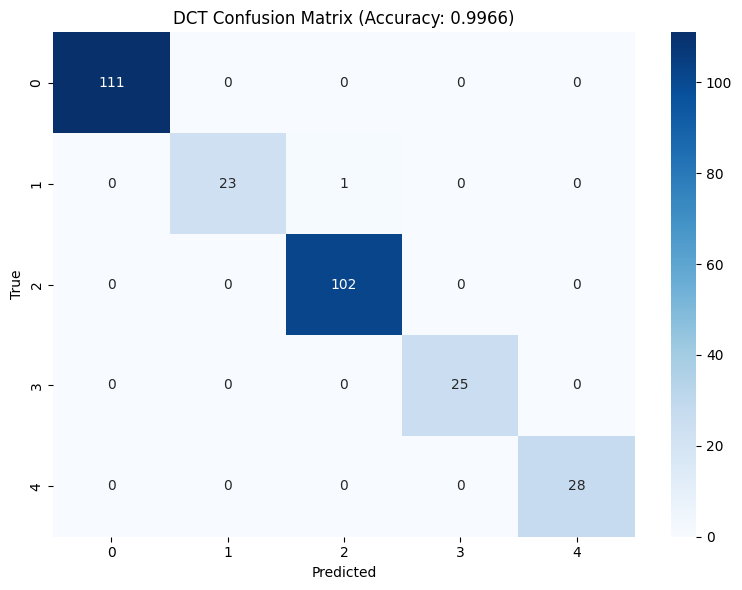


DCT Subject Identification (≥70%):
Patient 1: 111/111 (1.00) → IDENTIFIED
Patient 2: 23/24 (0.96) → IDENTIFIED
Patient 3: 102/102 (1.00) → IDENTIFIED
Patient 4: 25/25 (1.00) → IDENTIFIED
Patient 5: 28/28 (1.00) → IDENTIFIED


In [14]:
# Evaluate DCT-SVM
preds_dct = dct_svm.predict(X_dct_test)
acc_dct = accuracy_score(y_dct_test, preds_dct)
print("--- DCT-Based SVM Model Results")
print(f"Accuracy: {acc_dct:.4f}")
print(classification_report(y_dct_test, preds_dct))
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_dct_test, preds_dct)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"DCT Confusion Matrix (Accuracy: {acc_dct:.4f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("dct_confusion_matrix.png")
plt.show()

print("\nDCT Subject Identification (≥70%):")
for i in range(len(patients)):
    idx = np.where(y_dct_test == i)[0]
    if len(idx) == 0: continue
    correct = np.sum(preds_dct[idx] == i)
    rate = correct / len(idx)
    status = "IDENTIFIED" if rate >= 0.7 else "UNIDENTIFIED"
    print(f"Patient {i+1}: {correct}/{len(idx)} ({rate:.2f}) → {status}")

--- Wavelet-Based SVM Model Results
Accuracy: 0.9862
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       1.00      0.83      0.91        24
           2       0.96      1.00      0.98       102
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        28

    accuracy                           0.99       290
   macro avg       0.99      0.97      0.98       290
weighted avg       0.99      0.99      0.99       290



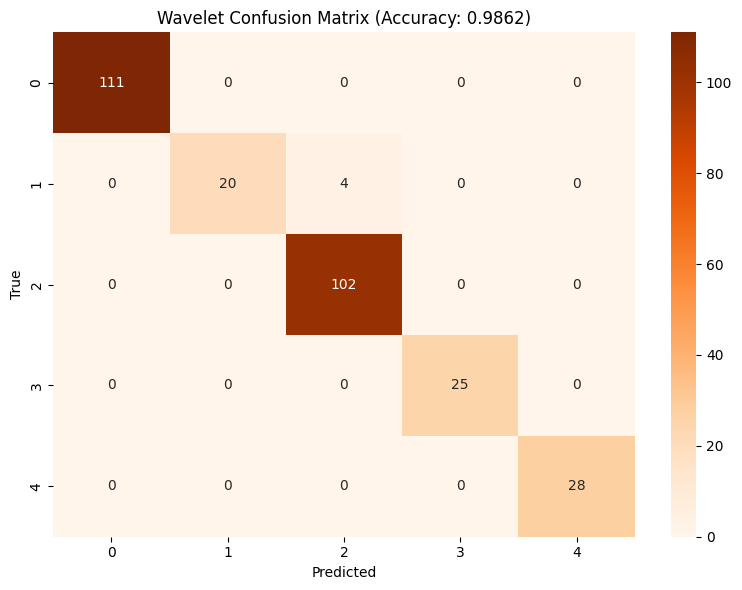


Wavelet Subject Identification (≥70%):
Patient 1: 111/111 (1.00) → IDENTIFIED
Patient 2: 20/24 (0.83) → IDENTIFIED
Patient 3: 102/102 (1.00) → IDENTIFIED
Patient 4: 25/25 (1.00) → IDENTIFIED
Patient 5: 28/28 (1.00) → IDENTIFIED


In [15]:
# Evaluate Wavelet-SVM
preds_wavelet = wavelet_svm.predict(X_wavelet_test)
acc_wavelet = accuracy_score(y_wavelet_test, preds_wavelet)
print("--- Wavelet-Based SVM Model Results")
print(f"Accuracy: {acc_wavelet:.4f}")
print(classification_report(y_wavelet_test, preds_wavelet))
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_wavelet_test, preds_wavelet)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title(f"Wavelet Confusion Matrix (Accuracy: {acc_wavelet:.4f})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("wavelet_confusion_matrix.png")
plt.show()

print("\nWavelet Subject Identification (≥70%):")
for i in range(len(patients)):
    idx = np.where(y_wavelet_test == i)[0]
    if len(idx) == 0: continue
    correct = np.sum(preds_wavelet[idx] == i)
    rate = correct / len(idx)
    status = "IDENTIFIED" if rate >= 0.7 else "UNIDENTIFIED"
    print(f"Patient {i+1}: {correct}/{len(idx)} ({rate:.2f}) → {status}")


---- Performance Comparison ----
DCT-Based SVM Accuracy: 0.9966
Wavelet-Based SVM Accuracy: 0.9862


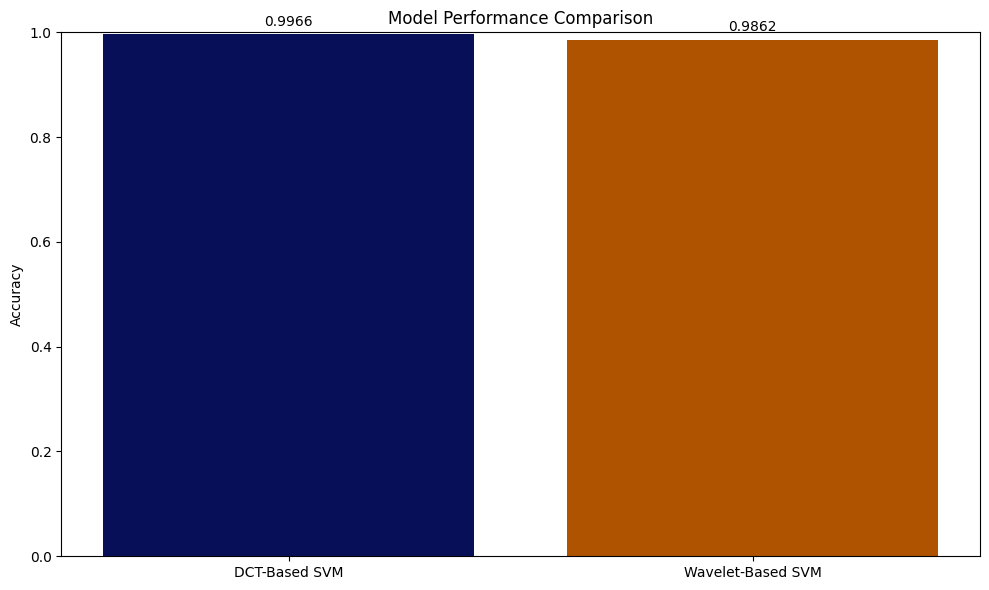

Saved models to dct_svm_model.pkl and wavelet_svm_model.pkl


In [41]:
# Compare Models
print("\n---- Performance Comparison ----")
print(f"DCT-Based SVM Accuracy: {acc_dct:.4f}")
print(f"Wavelet-Based SVM Accuracy: {acc_wavelet:.4f}")
plt.figure(figsize=(10, 6))
models = ['DCT-Based SVM', 'Wavelet-Based SVM']
accuracies = [acc_dct, acc_wavelet]
bars = plt.bar(models, accuracies, color=['#080f59', '#b05300'])  
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.0)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{accuracies[i]:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# Save models
joblib.dump(dct_svm, "dct_svm_model.pkl")
joblib.dump(wavelet_svm, "wavelet_svm_model.pkl")
print("Saved models to dct_svm_model.pkl and wavelet_svm_model.pkl")


Loading and processing ECG data...

Loaded 1447 segments
DCT feature size: 28
Wavelet feature size: 28

---- Training DCT-based SVM Model ----
Best SVM params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

--- DCT-Based SVM Model Results ---
Accuracy: 0.9966
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       1.00      0.96      0.98        24
           2       0.99      1.00      1.00       102
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        28

    accuracy                           1.00       290
   macro avg       1.00      0.99      0.99       290
weighted avg       1.00      1.00      1.00       290



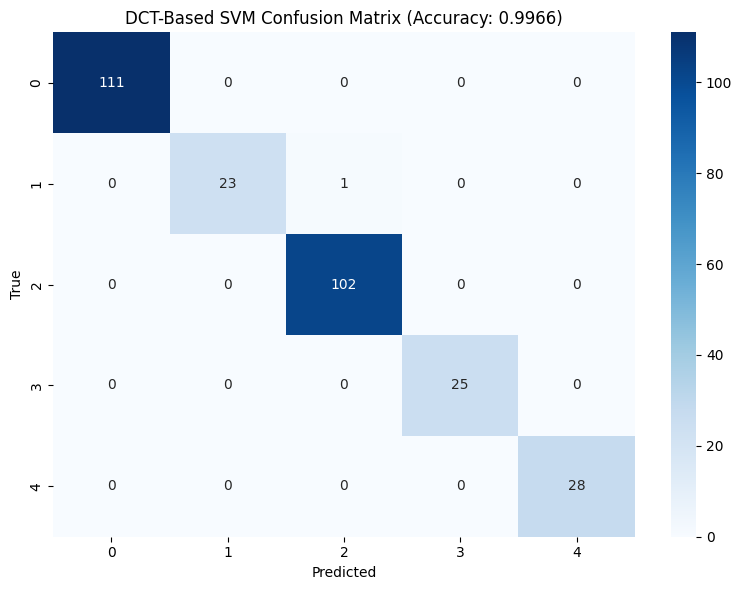


DCT-Based SVM Subject Identification (≥70% rule):
Patient 1: 111/111 (1.00) → IDENTIFIED
Patient 2: 23/24 (0.96) → IDENTIFIED
Patient 3: 102/102 (1.00) → IDENTIFIED
Patient 4: 25/25 (1.00) → IDENTIFIED
Patient 5: 28/28 (1.00) → IDENTIFIED

---- Training Wavelet-based SVM Model ----
Best SVM params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

--- Wavelet-Based SVM Model Results ---
Accuracy: 0.9862
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       1.00      0.83      0.91        24
           2       0.96      1.00      0.98       102
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        28

    accuracy                           0.99       290
   macro avg       0.99      0.97      0.98       290
weighted avg       0.99      0.99      0.99       290



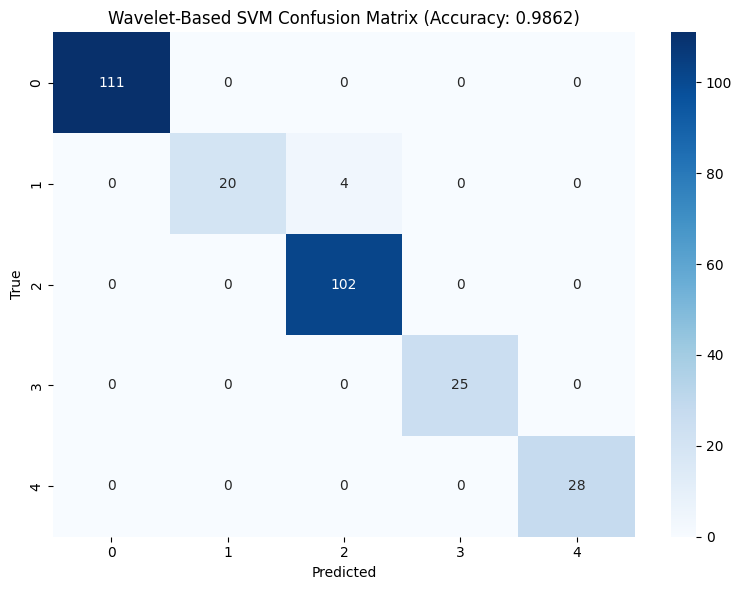


Wavelet-Based SVM Subject Identification (≥70% rule):
Patient 1: 111/111 (1.00) → IDENTIFIED
Patient 2: 20/24 (0.83) → IDENTIFIED
Patient 3: 102/102 (1.00) → IDENTIFIED
Patient 4: 25/25 (1.00) → IDENTIFIED
Patient 5: 28/28 (1.00) → IDENTIFIED

---- Performance Comparison ----
DCT-Based SVM Accuracy: 0.9966
Wavelet-Based SVM Accuracy: 0.9862


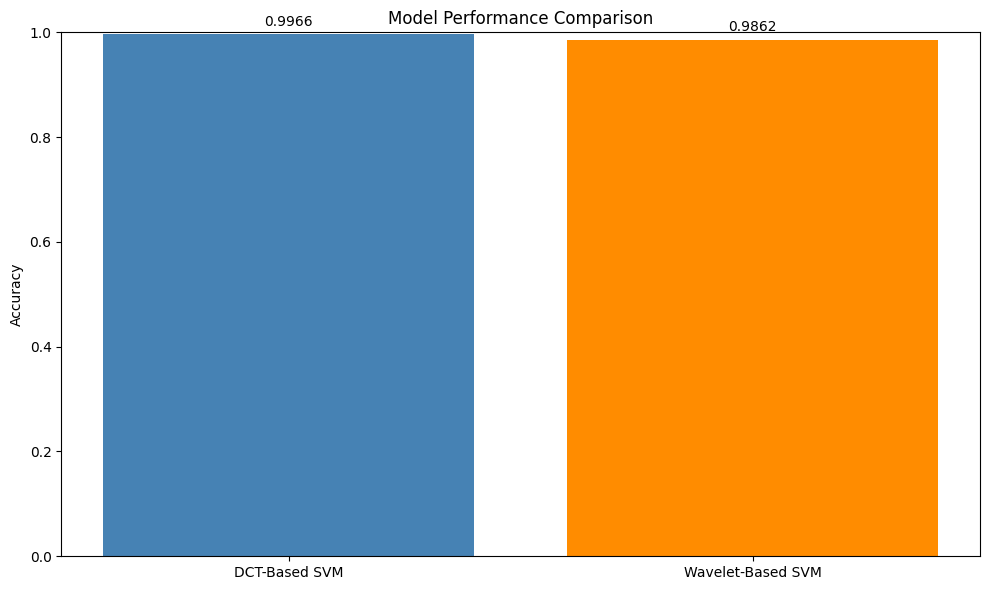

Saved models to dct_svm_model.pkl and wavelet_svm_model.pkl


In [11]:
import os
import numpy as np
import wfdb
from scipy.signal import butter, filtfilt, find_peaks
from scipy.fftpack import dct
from scipy.stats import skew, kurtosis
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- ECG Preprocessing ---
def bandpass_filter(signal, low=1, high=40.0, fs=1000, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, signal)

def preprocess_ecg(signal, fs=1000):
    filtered = bandpass_filter(signal, fs=fs)
    return filtered

# --- Feature Extraction ---
def extract_time_freq_features(ecg_seg, fs=1000):
    # Time-domain features
    time_feats = [np.mean(ecg_seg), np.std(ecg_seg), skew(ecg_seg), kurtosis(ecg_seg), np.sqrt(np.mean(ecg_seg**2))]
    
    # Basic frequency features (without DCT or wavelet)
    freqs = np.abs(np.fft.fft(ecg_seg))[:len(ecg_seg)//2]
    power_bands = [np.sum(freqs[1:10]), np.sum(freqs[10:50]), np.sum(freqs[50:150])]
    
    return np.concatenate((time_feats, power_bands))

def extract_dct_features(ecg_seg):
    # Extract only DCT coefficients
    dct_coeffs = dct(ecg_seg, norm='ortho')[:20]  # First 20 DCT coefficients
    return dct_coeffs

def extract_wavelet_features(ecg_seg):
    # Extract only wavelet features
    coeffs = pywt.wavedec(ecg_seg, 'db4', level=3)
    # Extract statistics from each wavelet coefficient level
    wavelet_feats = []
    for c in coeffs:
        wavelet_feats.extend([np.mean(np.abs(c)), np.std(c), np.max(np.abs(c)), 
                              np.sum(np.square(c)), np.sqrt(np.mean(np.square(c)))])
    return np.array(wavelet_feats)

# --- R-peak Based Segmentation ---
def segment_and_extract_features(ecg, fs=1000, segment_window=0.6):
    signal = preprocess_ecg(ecg, fs)
    r_peaks, _ = find_peaks(signal, distance=fs*0.6, height=np.mean(signal))
    base_features = []
    dct_features = []
    wavelet_features = []

    win = int(segment_window * fs / 2)
    for r in r_peaks:
        if r - win < 0 or r + win > len(ecg):
            continue
        segment = ecg[r - win:r + win]
        
        # Extract different feature sets
        base_feat = extract_time_freq_features(segment, fs)
        dct_feat = extract_dct_features(segment)
        wavelet_feat = extract_wavelet_features(segment)
        
        base_features.append(base_feat)
        dct_features.append(dct_feat)
        wavelet_features.append(wavelet_feat)

    return base_features, dct_features, wavelet_features

# --- Data Loader ---
def load_patient_data(base_path, patients, fs=1000):
    all_base_features = []
    all_dct_features = []
    all_wavelet_features = []
    all_labels = []

    for label, patient in enumerate(patients):
        patient_path = os.path.join(base_path, patient)
        for f in os.listdir(patient_path):
            if f.endswith('.dat'):
                record_name = f.replace('.dat', '')
                try:
                    record = wfdb.rdrecord(os.path.join(patient_path, record_name))
                    ecg = record.p_signal[:, 0]
                    base_feats, dct_feats, wavelet_feats = segment_and_extract_features(ecg, fs)
                    
                    all_base_features.extend(base_feats)
                    all_dct_features.extend(dct_feats)
                    all_wavelet_features.extend(wavelet_feats)
                    all_labels.extend([label] * len(base_feats))
                except Exception as e:
                    print(f"Failed to load {record_name}: {e}")

    # Create feature sets for comparison
    X_dct_combined = []
    X_wavelet_combined = []
    
    # Combine features properly
    for i in range(len(all_base_features)):
        X_dct_combined.append(np.concatenate((all_base_features[i], all_dct_features[i])))
        X_wavelet_combined.append(np.concatenate((all_base_features[i], all_wavelet_features[i])))
    
    return np.array(X_dct_combined), np.array(X_wavelet_combined), np.array(all_labels)

# --- SVM Classifier with Hyperparameter Tuning ---
def train_best_svm(X_train, y_train):
    params = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.001],
        'kernel': ['rbf']
    }
    grid = GridSearchCV(SVC(), params, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best SVM params: {grid.best_params_}")
    return grid.best_estimator_

# --- Evaluation ---
def evaluate_model(model, X_test, y_test, name, patient_count):
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    print(f"\n--- {name} Model Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n")
    print(classification_report(y_test, preds))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix (Accuracy: {accuracy:.4f})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.show()

    print(f"\n{name} Subject Identification (≥70% rule):")
    for i in range(patient_count):
        idx = np.where(y_test == i)[0]
        if len(idx) == 0:
            continue
        correct = np.sum(preds[idx] == i)
        identification_rate = correct / len(idx)
        status = "IDENTIFIED" if identification_rate >= 0.7 else "UNIDENTIFIED"
        print(f"Patient {i + 1}: {correct}/{len(idx)} ({identification_rate:.2f}) → {status}")
    
    return accuracy

# --- Main Training Loop ---
def train_and_evaluate(X_dct, X_wavelet, y, patient_count):
    # Create splits with same random state for fair comparison
    X_dct_train, X_dct_test, y_dct_train, y_dct_test = train_test_split(
        X_dct, y, stratify=y, test_size=0.2, random_state=42
    )
    
    X_wavelet_train, X_wavelet_test, y_wavelet_train, y_wavelet_test = train_test_split(
        X_wavelet, y, stratify=y, test_size=0.2, random_state=42
    )
    
    # Make sure we have the same test split for fair comparison
    assert np.array_equal(y_dct_test, y_wavelet_test), "Test splits do not match!"

    print("\n---- Training DCT-based SVM Model ----")
    dct_svm = train_best_svm(X_dct_train, y_dct_train)
    dct_accuracy = evaluate_model(dct_svm, X_dct_test, y_dct_test, "DCT-Based SVM", patient_count)
    
    print("\n---- Training Wavelet-based SVM Model ----")
    wavelet_svm = train_best_svm(X_wavelet_train, y_wavelet_train)
    wavelet_accuracy = evaluate_model(wavelet_svm, X_wavelet_test, y_wavelet_test, "Wavelet-Based SVM", patient_count)
    
    # Compare results
    print("\n---- Performance Comparison ----")
    print(f"DCT-Based SVM Accuracy: {dct_accuracy:.4f}")
    print(f"Wavelet-Based SVM Accuracy: {wavelet_accuracy:.4f}")
    
    # Plot accuracy comparison
    plt.figure(figsize=(10, 6))
    models = ['DCT-Based SVM', 'Wavelet-Based SVM']
    accuracies = [dct_accuracy, wavelet_accuracy]
    bars = plt.bar(models, accuracies, color=['steelblue', 'darkorange'])
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.ylim(0, 1.0)
    
    # Add accuracy values on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{accuracies[i]:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()
    
    # Save models
    joblib.dump(dct_svm, "dct_svm_model.pkl")
    joblib.dump(wavelet_svm, "wavelet_svm_model.pkl")
    print(f"Saved models to dct_svm_model.pkl and wavelet_svm_model.pkl")

# --- Run Pipeline ---
if __name__ == "__main__":
    ptb_path = "/kaggle/input/hci-projectdataset-ecg/"
    patients = ['patient049', 'patient071', 'patient082', 'patient191', 'patient210']

    print("Loading and processing ECG data...")
    X_dct, X_wavelet, y = load_patient_data(ptb_path, patients)

    print(f"\nLoaded {len(X_dct)} segments")
    print(f"DCT feature size: {X_dct.shape[1]}")
    print(f"Wavelet feature size: {X_wavelet.shape[1]}")
    
    train_and_evaluate(X_dct, X_wavelet, y, patient_count=len(patients))

In [ ]:
# import os
# import numpy as np
# import wfdb
# from scipy.signal import butter, filtfilt, find_peaks
# from scipy.fftpack import dct
# import pywt
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.preprocessing import StandardScaler

# # --- ECG Preprocessing ---
# def bandpass_filter(signal, low=0.5, high=40.0, fs=1000, order=4):
#     """Apply bandpass filter to remove noise from ECG signal"""
#     nyq = 0.5 * fs
#     b, a = butter(order, [low / nyq, high / nyq], btype='band')
#     return filtfilt(b, a, signal)

# def preprocess_ecg(signal, fs=1000):
#     """Complete ECG preprocessing pipeline"""
#     # Apply bandpass filtering to remove noise
#     filtered = bandpass_filter(signal, fs=fs)
#     return filtered

# # --- ECG Segmentation ---
# def segment_ecg(ecg, fs=1000, segment_window=0.6):
#     """Segment ECG signal based on R-peaks"""
#     # Preprocess signal first for better R-peak detection
#     signal = preprocess_ecg(ecg, fs)
    
#     # Find R-peaks
#     r_peaks, _ = find_peaks(signal, distance=fs*0.5, height=0.6*np.max(signal))
    
#     segments = []
#     # Extract window around each R-peak
#     win = int(segment_window * fs / 2)
#     for r in r_peaks:
#         if r - win >= 0 and r + win < len(ecg):
#             # Use original signal (not filtered) for feature extraction
#             segment = ecg[r - win:r + win]
#             segments.append(segment)
    
#     return segments

# # --- DCT Feature Extraction ---
# def extract_dct_features(ecg_seg, num_coeffs=20):
#     """Extract DCT coefficients from ECG segment"""
#     # Compute DCT
#     dct_coeffs = dct(ecg_seg, norm='ortho')
#     # Use only first num_coeffs coefficients
#     return dct_coeffs[:num_coeffs]

# # --- Wavelet Feature Extraction ---
# def extract_wavelet_features(ecg_seg):
#     """Extract wavelet coefficients from ECG segment"""
#     # Perform wavelet decomposition using db4 wavelet
#     coeffs = pywt.wavedec(ecg_seg, 'db4', level=4)
    
#     # Extract features from each decomposition level
#     wavelet_feats = []
#     for c in coeffs:
#         # Use meaningful statistics from each level
#         wavelet_feats.extend([
#             np.mean(np.abs(c)),     # Mean absolute value
#             np.std(c),              # Standard deviation
#             np.max(np.abs(c)),      # Maximum absolute value
#             np.sum(np.square(c)),   # Energy
#         ])
    
#     return np.array(wavelet_feats)

# # --- Feature Extraction Pipeline ---
# def extract_features_from_segments(segments):
#     """Extract both DCT and wavelet features from segments"""
#     dct_features = []
#     wavelet_features = []
    
#     for segment in segments:
#         # Extract DCT features
#         dct_feat = extract_dct_features(segment)
#         # Extract wavelet features
#         wavelet_feat = extract_wavelet_features(segment)
        
#         dct_features.append(dct_feat)
#         wavelet_features.append(wavelet_feat)
    
#     return np.array(dct_features), np.array(wavelet_features)

# # --- Data Loading ---
# def load_patient_data(base_path, patients, fs=1000):
#     """Load ECG data for the specified patients"""
#     all_dct_features = []
#     all_wavelet_features = []
#     all_labels = []
#     patient_segments = {i: [] for i in range(len(patients))}

#     for label, patient in enumerate(patients):
#         patient_path = os.path.join(base_path, patient)
#         print(f"Processing patient: {patient}")
        
#         for f in os.listdir(patient_path):
#             if f.endswith('.dat'):
#                 record_name = f.replace('.dat', '')
#                 try:
#                     # Load ECG record
#                     record = wfdb.rdrecord(os.path.join(patient_path, record_name))
#                     ecg = record.p_signal[:, 0]  # Use first channel
                    
#                     # Segment ECG
#                     segments = segment_ecg(ecg, fs)
                    
#                     if segments:
#                         # Extract features
#                         dct_feats, wavelet_feats = extract_features_from_segments(segments)
                        
#                         # Store features
#                         all_dct_features.extend(dct_feats)
#                         all_wavelet_features.extend(wavelet_feats)
#                         all_labels.extend([label] * len(segments))
                        
#                         # Store segment count per patient
#                         patient_segments[label].extend([1] * len(segments))
                        
#                 except Exception as e:
#                     print(f"Failed to load {record_name}: {e}")
    
#     return np.array(all_dct_features), np.array(all_wavelet_features), np.array(all_labels), patient_segments

# # --- SVM Training with Hyperparameter Optimization ---
# def train_svm_model(X_train, y_train, feature_type):
#     """Train SVM model with hyperparameter optimization"""
#     print(f"\n--- Training SVM with {feature_type} features ---")
    
#     # Define parameter grid for grid search
#     param_grid = {
#         'C': [0.1, 1, 10, 100],
#         'gamma': ['scale', 'auto', 0.01, 0.001],
#         'kernel': ['linear', 'rbf', 'poly'],
#         'degree': [2, 3] # for poly kernel
#     }
    
#     # Perform grid search with cross-validation
#     grid = GridSearchCV(
#         SVC(probability=True),
#         param_grid,
#         cv=5,
#         scoring='accuracy',
#         n_jobs=-1,
#         verbose=1
#     )
    
#     # Fit grid search
#     grid.fit(X_train, y_train)
    
#     # Report best parameters
#     print(f"Best parameters: {grid.best_params_}")
#     print(f"Best cross-validation accuracy: {grid.best_score_:.4f}")
    
#     return grid.best_estimator_

# # --- Evaluation with >70% Rule ---
# def evaluate_model(model, X_test, y_test, feature_type, patient_segments):
#     """Evaluate model with >70% identification rule"""
#     print(f"\n--- Evaluating {feature_type} model ---")
    
#     # Get predictions for test data
#     y_pred = model.predict(X_test)
    
#     # Calculate accuracy
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"Test accuracy: {accuracy:.4f}")
    
#     # Print classification report
#     print("\nClassification report:")
#     print(classification_report(y_test, y_pred))
    
#     # Create and plot confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title(f'Confusion Matrix - {feature_type} Features (Accuracy: {accuracy:.4f})')
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.savefig(f'{feature_type.lower()}_confusion_matrix.png')
#     plt.close()
    
#     # Evaluate with >70% rule for each subject
#     print("\n--- Subject Identification with >70% Rule ---")
    
#     # Get unique subject labels
#     subjects = np.unique(y_test)
    
#     identified_count = 0
#     for subject in subjects:
#         # Get indices for this subject
#         indices = np.where(y_test == subject)[0]
        
#         # Get predictions for this subject's segments
#         subject_preds = y_pred[indices]
        
#         # Count predictions for each class
#         unique_preds, counts = np.unique(subject_preds, return_counts=True)
        
#         # Calculate percentage of correct predictions
#         total_segments = len(indices)
#         correct_segments = np.sum(subject_preds == subject)
#         correct_percentage = correct_segments / total_segments if total_segments > 0 else 0
        
#         # Apply >70% rule
#         if correct_percentage >= 0.7:
#             status = "IDENTIFIED"
#             identified_count += 1
#         else:
#             status = "NOT IDENTIFIED"
        
#         print(f"Subject {subject}: {correct_segments}/{total_segments} correct ({correct_percentage:.2%}) - {status}")
    
#     identification_rate = identified_count / len(subjects)
#     print(f"\nOverall identification rate: {identification_rate:.2%}")
    
#     return accuracy, identification_rate

# # --- Feature Comparison ---
# def compare_features(dct_accuracy, wavelet_accuracy, dct_id_rate, wavelet_id_rate):
#     """Compare performance of DCT and wavelet features"""
#     print("\n--- Feature Comparison ---")
#     print(f"DCT Features - Accuracy: {dct_accuracy:.4f}, Identification Rate: {dct_id_rate:.2%}")
#     print(f"Wavelet Features - Accuracy: {wavelet_accuracy:.4f}, Identification Rate: {wavelet_id_rate:.2%}")
    
#     # Create comparison plot
#     plt.figure(figsize=(10, 6))
    
#     metrics = ['Accuracy', 'Identification Rate']
#     dct_scores = [dct_accuracy, dct_id_rate]
#     wavelet_scores = [wavelet_accuracy, wavelet_id_rate]
    
#     x = np.arange(len(metrics))
#     width = 0.35
    
#     plt.bar(x - width/2, dct_scores, width, label='DCT Features')
#     plt.bar(x + width/2, wavelet_scores, width, label='Wavelet Features')
    
#     plt.xlabel('Metrics')
#     plt.ylabel('Score')
#     plt.title('Feature Performance Comparison')
#     plt.xticks(x, metrics)
#     plt.ylim(0, 1.0)
#     plt.legend()
    
#     # Add values on top of bars
#     for i, v in enumerate(dct_scores):
#         plt.text(i - width/2, v + 0.01, f'{v:.2%}', ha='center')
    
#     for i, v in enumerate(wavelet_scores):
#         plt.text(i + width/2, v + 0.01, f'{v:.2%}', ha='center')
    
#     plt.tight_layout()
#     plt.savefig('feature_comparison.png')
#     plt.close()
    
#     # Determine better feature set
#     if dct_accuracy > wavelet_accuracy:
#         print("\nDCT features performed better for classification accuracy.")
#     elif wavelet_accuracy > dct_accuracy:
#         print("\nWavelet features performed better for classification accuracy.")
#     else:
#         print("\nBoth feature sets performed equally for classification accuracy.")
    
#     if dct_id_rate > wavelet_id_rate:
#         print("DCT features performed better for subject identification.")
#     elif wavelet_id_rate > dct_id_rate:
#         print("Wavelet features performed better for subject identification.")
#     else:
#         print("Both feature sets performed equally for subject identification.")

# # --- Testing Individual Authentication ---
# def test_authentication(model, X_test, y_test, feature_type):
#     """Test authentication process for each subject"""
#     print(f"\n--- Testing {feature_type} Authentication System ---")
    
#     # Get unique subject labels
#     subjects = np.unique(y_test)
    
#     for subject in subjects:
#         # Get indices for this subject
#         indices = np.where(y_test == subject)[0]
        
#         # Get test data for this subject
#         subject_X = X_test[indices]
        
#         # Get predictions
#         preds = model.predict(subject_X)
        
#         # Apply >70% rule
#         unique_preds, counts = np.unique(preds, return_counts=True)
#         pred_percentages = {subjects[i]: count/len(preds) for i, count in zip(unique_preds, counts)}
        
#         max_class = max(pred_percentages, key=pred_percentages.get)
#         max_percentage = pred_percentages[max_class]
        
#         if max_percentage >= 0.7:
#             if max_class == subject:
#                 auth_result = f"CORRECTLY IDENTIFIED as Subject {max_class}"
#             else:
#                 auth_result = f"INCORRECTLY IDENTIFIED as Subject {max_class}"
#         else:
#             auth_result = "NOT IDENTIFIED (no class reached 70% threshold)"
        
#         print(f"Subject {subject} test: {auth_result} ({max_percentage:.2%})")
        
#         # Print prediction distribution
#         print("Prediction distribution:")
#         for s in pred_percentages:
#             print(f"  Subject {s}: {pred_percentages[s]:.2%}")

# # --- Main Function ---
# def main():
#     # Define patients to use from PTB database
#     ptb_path = "/kaggle/input/hci-projectdataset-ecg/"  # Update this path to your PTB database location
#     patients = ['patient049', 'patient071', 'patient082', 'patient191', 'patient210']  # Replace with actual patient IDs
    
#     print("Step 1: Loading ECG data for 5 subjects...")
#     dct_features, wavelet_features, labels, patient_segments = load_patient_data(ptb_path, patients)
    
#     print(f"\nLoaded {len(dct_features)} ECG segments")
#     print(f"DCT feature dimension: {dct_features.shape[1]}")
#     print(f"Wavelet feature dimension: {wavelet_features.shape[1]}")
    
#     # Step 2: Normalize features
#     print("\nStep 2: Normalizing features...")
#     dct_scaler = StandardScaler()
#     wavelet_scaler = StandardScaler()
    
#     normalized_dct = dct_scaler.fit_transform(dct_features)
#     normalized_wavelet = wavelet_scaler.fit_transform(wavelet_features)
    
#     # Step 3: Split data for training and testing
#     print("\nStep 3: Splitting data into training and testing sets...")
#     X_dct_train, X_dct_test, y_dct_train, y_dct_test = train_test_split(
#         normalized_dct, labels, test_size=0.3, stratify=labels, random_state=42
#     )
    
#     X_wavelet_train, X_wavelet_test, y_wavelet_train, y_wavelet_test = train_test_split(
#         normalized_wavelet, labels, test_size=0.3, stratify=labels, random_state=42
#     )
    
#     # Step 4: Train SVM models
#     print("\nStep 4: Training SVM models with different feature sets...")
#     dct_model = train_svm_model(X_dct_train, y_dct_train, "DCT")
#     wavelet_model = train_svm_model(X_wavelet_train, y_wavelet_train, "Wavelet")
    
#     # Save models
#     joblib.dump(dct_model, "dct_svm_model.pkl")
#     joblib.dump(wavelet_model, "wavelet_svm_model.pkl")
#     joblib.dump(dct_scaler, "dct_scaler.pkl")
#     joblib.dump(wavelet_scaler, "wavelet_scaler.pkl")
#     print("\nSaved models and scalers to disk")
    
#     # Step 5: Evaluate models
#     print("\nStep 5: Evaluating models with >70% identification rule...")
#     dct_accuracy, dct_id_rate = evaluate_model(dct_model, X_dct_test, y_dct_test, "DCT", patient_segments)
#     wavelet_accuracy, wavelet_id_rate = evaluate_model(wavelet_model, X_wavelet_test, y_wavelet_test, "Wavelet", patient_segments)
    
#     # Step a6: Compare features
#     print("\nStep 6: Comparing feature performance...")
#     compare_features(dct_accuracy, wavelet_accuracy, dct_id_rate, wavelet_id_rate)
    
#     # Step 7: Test authentication
#     print("\nStep 7: Testing authentication system...")
#     print("\n--- DCT-based Authentication System ---")
#     test_authentication(dct_model, X_dct_test, y_dct_test, "DCT")
    
#     print("\n--- Wavelet-based Authentication System ---")
#     test_authentication(wavelet_model, X_wavelet_test, y_wavelet_test, "Wavelet")

# if __name__ == "__main__":
#     main()

In [ ]:

    plt.plot(r_peaks, filtered[r_peaks], 'rx', label="Detected R-peaks")